# Classify medical abstracts

Samuel Martey Okoe-Mensah, master's thesis 2023

# Choose workflow

In [ ]:
workflows = {0: {'dropstop': False, 'synonyms': False, 'parents': False, 'ngrams': False, 'nrfeats': 1000},
             1: {'dropstop': True, 'synonyms': False, 'parents': False, 'ngrams': False, 'nrfeats': 1000},
             2: {'dropstop': True, 'synonyms': True, 'parents': False, 'ngrams': False, 'nrfeats': 1000},
             3: {'dropstop': True, 'synonyms': True, 'parents': True, 'ngrams': False, 'nrfeats': 1000},
             4: {'dropstop': True, 'synonyms': False, 'parents': False, 'ngrams': 3, 'nrfeats': 1000},
             5: {'dropstop': True, 'synonyms': True, 'parents': False, 'ngrams': 3, 'nrfeats': 1000},
             6: {'dropstop': True, 'synonyms': True, 'parents': True, 'ngrams': 3, 'nrfeats': 1000},
             7: {'dropstop': False, 'synonyms': True, 'parents': True, 'ngrams': 3, 'nrfeats': 1000},
             8: {'dropstop': False, 'synonyms': False, 'parents': False, 'ngrams': 3, 'nrfeats': 1000},
             9: {'dropstop': False, 'synonyms': False, 'parents': False, 'ngrams': 3, 'nrfeats': 2000},
             10: {'dropstop': True, 'synonyms': True, 'parents': True, 'ngrams': 3, 'nrfeats': 2000}}


Choose only one of the following workflows before continuing.

In [ ]:
Workflow = 0

In [ ]:
Workflow = 1

In [ ]:
Workflow = 2

In [ ]:
Workflow = 3

In [ ]:
Workflow = 4

In [ ]:
Workflow = 5

In [ ]:
Workflow = 6

In [ ]:
Workflow = 7

In [ ]:
Workflow = 8

In [ ]:
Workflow = 9

In [ ]:
Workflow = 10

After choosing a workflow, continue here.

In [ ]:
print(Workflow)
print(workflows[Workflow])
workflow = str(Workflow)

10
{'dropstop': True, 'synonyms': True, 'parents': True, 'ngrams': 3, 'nrwords': 2000}


# 0. Preliminaries

Needs to be done only once per session.


Connect to Google Drive where data is stored.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Decide where the files with result data will be placed. Make helper functions for writing text, figures and LaTeX tables to files in that folder, with appropriate settings.

In [ ]:
doc_path = 'drive/MyDrive/Colab Notebooks/Samuel/Doc/' # change to your folder

def write_text (data, file):
  with open(doc_path + file + workflow + '.tex', 'w') as out:
    print(data, file=out)

def write_fig (fig, file):
  fig.savefig(doc_path + file + workflow, dpi=150, bbox_inches='tight')

def write_table (styled_df, file, caption, label,
                 column_format=None, position='hbtp'):
  styled_df.format_index(escape="latex", axis=0)
  styled_df.format_index(escape="latex", axis=1)
  styled_df.to_latex(doc_path + file + workflow + '.tex', position=position,
                     caption=caption, label=label+workflow, column_format=column_format,
                     position_float='centering', hrules=True, convert_css=True)

Load modules and set random seeds for replicability of results.

In [ ]:
import numpy as np
import pandas as pd
import re
#from collections import Counter
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)
from tensorflow import math
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
eng_stopwords = stopwords.words('english')
#from nltk.util import ngrams
import json
import seaborn as sns

# if desired, set seeds for replicability of results
np.random.seed(41)
tf.random.set_seed(42)

2.14.0


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 1. Importing, checking and tokenizing the data.

Needs to be done only once per session.

Change the path if necessary.

In [ ]:
data_path = '/content/drive/My Drive/Colab Notebooks/Samuel/Data/'

Read the data file containing the annotated corpus

In [ ]:
data = pd.read_csv(data_path + 'abstracts.tsv', sep='\t')
data

,labels,texts
0,1,Background: Evidence for the effects of exerci...
1,1,Objective: To investigate the effect of a 2-ye...
2,1,Background: Modifiable vascular and lifestyle-...
3,1,Background: Finnish Geriatric Intervention Stu...
4,1,Introduction: The 2-year Finnish Geriatric Int...
...,...,...
145,0,Delirium is a significant problem for older ho...
146,0,Maternal exposure to environmental agents thro...
147,0,To investigate the effect of maternal dietary ...
148,0,Background: Hospitalization in older adults is...


In [ ]:
write_text(data, 'samples')

Show some labels and part of a text.

In [ ]:
data_labels = data['labels']
data_labels[:10]

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: labels, dtype: int64

In [ ]:
data['texts'][0][:100]

'Background: Evidence for the effects of exercise and dietary interventions on cognition from long-te'

Show distribution of labels.

In [ ]:
class_dist = pd.concat([data_labels.value_counts(),
                        data_labels.value_counts(normalize=True) * 100],
                       axis=1,
                       keys=('count', '%'))
class_dist

,count,%
1,89,59.333333
0,61,40.666667


In [ ]:
class_dist.reset_index(inplace=True)
class_dist.columns = ['label', 'count', '%']
class_dist_styled = class_dist.style.format(precision=1).hide(axis=0)
class_dist_styled

label,count,%
1,89,59.3
0,61,40.7


Write to file as LaTeX table.

In [ ]:
write_table(class_dist_styled, 'class-distribution',
            caption='Articles per class (1 = included, 0 = excluded).',
            label='tab:dist-articles', column_format='ccc')


# 2. Functions for feature enhancement: n-grams, stop words and NEO

Needs to be done only once per session.

## 2.1 N-grams

Define a simple function to compute n-grams from tokens. Use underscore in n-grams.

In [ ]:
def n_grams (seq, n=3):
  return ['_'.join(tpl) for tpl in zip(*[seq[i:] for i in range(n)])]

n_grams(['a','b','c','d','e'])

['a_b_c', 'b_c_d', 'c_d_e']

## 2.2 Ontology

Optionally, enrich text with terms from ontology. Load the NEO ontology dict from json.

In [ ]:
with open(data_path + 'neo.json') as infile:
  neodict = json.load(infile)

Try getting synonyms from NEO for a word.

In [ ]:
def try_synonyms(word, ontodict=neodict):
  val = ontodict.get(word)
  if val:
    return val.get('Synonyms')

Test.

In [ ]:
print(try_synonyms('ataxia'))
print(try_synonyms('dystaxia'))
print(try_synonyms('nonexistent'))

['dyssynergia', 'dystaxia']
[]
None


Try getting parents from NEO for a word.

In [ ]:
def try_parents(word, ontodict=neodict):
  val = ontodict.get(word)
  if val:
    return val.get('Parents')

Test.

In [ ]:
print(try_parents('ataxia'))
print(try_parents('dystaxia'))
print(try_parents('sign'))

['cerebellar_signs']
['ataxia']
None


Function to split multi-word terms unless n-grams are added.

In [ ]:
def split_terms(terms):
  if not workflows[Workflow]['ngrams']:
    # split multi-words into a flat list
    return {s for sublist in [t.split('_') for t in terms] for s in sublist}
  else:
    return set(terms)

split_terms(['cerebellar_signs', 'hypertonia', 'weight_gain', 'weight'])

{'cerebellar_signs', 'hypertonia', 'weight', 'weight_gain'}

Function to add synonyms from NEO.

In [ ]:
def all_synonyms(toks):
  new = set()
  for w in toks:
    synonyms = try_synonyms(w)
    if synonyms:
      synonyms = split_terms(synonyms)
      print('Adding synonyms ', synonyms, 'for', w)
      new = new | synonyms
  #if new:
    #print('Adding all synonyms ', new)
  return new

Test.

In [ ]:
print(all_synonyms(['ataxia', 'weakness_arm']))

Adding synonyms  {'dystaxia', 'dyssynergia'} for ataxia
Adding synonyms  {'monoparesis_of_arm'} for weakness_arm
{'monoparesis_of_arm', 'dystaxia', 'dyssynergia'}


Function to add parents from NEO.

In [ ]:
def all_parents(toks):
  new = set()
  for w in toks:
    parents = try_parents(w)
    if parents:
      parents = split_terms(parents)
      print('Adding parents ', parents, 'for', w)
      new = new | parents
  #if new:
    # print('Adding all parents', new)
  return new

In [ ]:
print(all_parents(['ataxia', 'weakness_arm']))

Adding parents  {'cerebellar_signs'} for ataxia
Adding parents  {'weakness_limb'} for weakness_arm
{'cerebellar_signs', 'weakness_limb'}


Depending on workflow, add synonyms and/or parents.

In [ ]:
Neo = set()

In [ ]:
def enrich_neo(tokenlist):
  global Neo
  if workflows[Workflow]['synonyms'] or workflows[Workflow]['parents']:
    tokenset = set(tokenlist)
    new = set()
    if workflows[Workflow]['synonyms']:
      new = new | all_synonyms(tokenset)
    if workflows[Workflow]['parents']:
      new = new | all_parents(tokenset)
    if new:
      new = new - tokenset
      print('Adding:', new)
      Neo = Neo | new
      tokenlist = list(tokenset | new)
  return tokenlist

In [ ]:
print(enrich_neo(['The', 'patient', 'has', 'ataxia', 'agitated', 'agitation']))

Adding synonyms  {'agitated'} for agitation
Adding synonyms  {'dystaxia', 'dyssynergia'} for ataxia
Adding synonyms  {'agitation'} for agitated
Adding parents  {'cerebellar_signs'} for ataxia
Adding parents  {'abnormal_affect'} for agitated
Adding: {'cerebellar_signs', 'abnormal_affect', 'dystaxia', 'dyssynergia'}
['agitation', 'patient', 'dystaxia', 'dyssynergia', 'cerebellar_signs', 'has', 'abnormal_affect', 'ataxia', 'The', 'agitated']


In [ ]:
print(Neo)
write_text(Neo, 'neo')

{'cerebellar_signs', 'abnormal_affect', 'dystaxia', 'dyssynergia'}


## 2.3 Stop words


Medical stop words.

In [ ]:
with open(data_path + 'med-stopwords.txt') as infile:
  med_stopwords = infile.read().splitlines()
print(len(med_stopwords), 'medical stop words read.')
print(med_stopwords[:12])

104 medical stop words read.
['0', '1', '2', '3', 'a', 'aim', 'aims', 'and', 'at', 'background', 'caps', 'capsule']


General English stop words.

In [ ]:
print(len(eng_stopwords), 'English stop words from NLTK.')
print(eng_stopwords[:12])

179 English stop words from NLTK.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll"]


Union of medical stop words and NLTK stop words.

In [ ]:
allstopwords = set(med_stopwords).union(set(stopwords.words('english')))
len(allstopwords)

266

Function to remove stopwords in all texts.

In [ ]:
def remove_stopwords (toklist):
  return [tok for tok in toklist if tok not in allstopwords]

#3. Execute preprocessing according to workflows

Must be done for each workflow.

Make a simple tokenizer and tokenize all texts.

In [ ]:
def word_tokens (text):
  return re.findall(r'[\w-]+', text.casefold())

tokenized_texts = [word_tokens(t) for t in data['texts']]
print(tokenized_texts[0][:12])

['background', 'evidence', 'for', 'the', 'effects', 'of', 'exercise', 'and', 'dietary', 'interventions', 'on', 'cognition']


## 3.1 Add n-grams, depending on workflow

In [ ]:
N = workflows[Workflow]['ngrams']
if N:
  print(f'Adding {N}-grams')
  for txt in tokenized_texts:
    txt.extend(n_grams(txt, N))

Adding 3-grams


In [ ]:
print(tokenized_texts[0][:12])
print(tokenized_texts[0][-12:])

['background', 'evidence', 'for', 'the', 'effects', 'of', 'exercise', 'and', 'dietary', 'interventions', 'on', 'cognition']
['diet_on_cognition', 'on_cognition_keywords', 'cognition_keywords_aerobic', 'keywords_aerobic_exercise', 'aerobic_exercise_cognitive', 'exercise_cognitive_function', 'cognitive_function_healthy', 'function_healthy_diet', 'healthy_diet_older', 'diet_older_individuals', 'older_individuals_resistance', 'individuals_resistance_exercise']


## 3.2 NEO enrichment, depending on workflow.

In [ ]:
Neo = set()
enriched_texts = [enrich_neo(t) for t in tokenized_texts]

Adding parents  {'sign'} for age
Adding: {'sign'}
Adding parents  {'sign'} for age
Adding: {'sign'}
Adding parents  {'age'} for elderly
Adding parents  {'sign'} for age
Adding parents  {'symptom'} for pain
Adding parents  {'impaired_cognition'} for dementia
Adding: {'sign', 'impaired_cognition', 'symptom'}
Adding parents  {'sign'} for age
Adding parents  {'impaired_cognition'} for dementia
Adding parents  {'sign'} for onset
Adding: {'sign', 'impaired_cognition'}
Adding parents  {'sign'} for age
Adding parents  {'impaired_cognition'} for dementia
Adding parents  {'age'} for elderly
Adding: {'sign', 'impaired_cognition'}
Adding parents  {'sign'} for age
Adding parents  {'impaired_cognition'} for dementia
Adding: {'sign', 'impaired_cognition'}
Adding parents  {'endocrine_symptoms'} for diabetes
Adding parents  {'impaired_cognition'} for dementia
Adding parents  {'cardiovascular_symptoms'} for hypertension
Adding parents  {'weight_gain'} for obesity
Adding parents  {'course'} for static
Ad

Check some texts.

In [ ]:
for i in range(min([6, len(data_labels)])):
  print(data_labels[i], enriched_texts[i][:12])
  print(data_labels[i], enriched_texts[i][-12:])

1 ['outcome_was_the', 'tests', 'from_sfas_the', 'investigate_the_independent', 'control_group_net', 'sign', 'kcal', 'independent', 'the_control_group', 'cerad-ts_changes_were', 'controlled', 'registry']
1 ['wk_and_at', '2', 'methods', 'methods_we_conducted', 'but_there_was', 'waist', 'global_cognition_measured', 'conducted', 'evidence_for_the', 'the_resistance_exercise', 'measured', 'adjusted']
1 ['improvement', 'social_activity_may', 'prevent', 'the_baseline_who', 'after', 'group_had_a', 'who_were_at', 'relatively_stable_based', '043', 'randomized_controlled_trial', 'disability', 'it']
1 ['significance', '-0_95_95', 'effects_on_functional', 'fairly', 'perform', 'difference_in_the', 'to_prevent_cognitive', 'nct01041989', 'no_difficulties_to', 'prevent_cognitive_impairment', 'a_total_of', 'results_the_mean']
1 ['and_cognition_at', 'all_participants_with', 'impaired_cognition', 'factors_aging_and', 'disability', 'findings_from_this', 'multidomain', 'fund', 'sign', '153', 'the_control_gro

These are all terms added by NEO to any of the texts.

In [ ]:
print(Neo)
write_text(', '.join(Neo), 'neo')

{'aggressive_behavior', 'course', 'emesis', 'difficulty_swallowing', 'apathy', 'impaired_cognition', 'impaired_swallowing', 'sign', 'aggressive', 'GI_symptoms', 'consitutitional_symptoms', 'urinary_symptoms', 'cardiovascular_symptoms', 'respiratory_symptoms', 'restless', 'ENT_symptoms', 'weight_gain', 'altered_behavior', 'symptom', 'endocrine_symptoms', 'withdrawn', 'hyperpathia', 'agitated', 'age', 'abnormal_affect', 'neuromuscular_symptoms', 'hypertonia', 'sensory_finding', 'bowel_problems', 'loss_of_equilibrium'}


## 3.3 Remove stop words, depending on workflow.

In [ ]:
if workflows[Workflow]['dropstop']:
  print('Removing stop words')
  data_texts = [remove_stopwords(t) for t in enriched_texts]
else:
  print('Keeping stop words')
  data_texts = enriched_texts

Removing stop words


Check some texts again.

In [ ]:
for i in range(min([6, len(data_labels)])):
  print(data_labels[i], data_texts[i][:12])
  print(data_labels[i], data_texts[i][-12:])

1 ['outcome_was_the', 'from_sfas_the', 'investigate_the_independent', 'control_group_net', 'kcal', 'independent', 'the_control_group', 'cerad-ts_changes_were', 'controlled', 'registry', 'fiber_1000_kcal', 'consortium_to_establish']
1 ['across', 'least_moderate-intensity_aerobic', 'wk_and_at', 'methods_we_conducted', 'but_there_was', 'waist', 'global_cognition_measured', 'conducted', 'evidence_for_the', 'the_resistance_exercise', 'measured', 'adjusted']
1 ['improvement', 'social_activity_may', 'prevent', 'the_baseline_who', 'group_had_a', 'who_were_at', 'relatively_stable_based', '043', 'randomized_controlled_trial', 'disability', 'multidomain', 'daily_functioning_of']
1 ['significance', '-0_95_95', 'effects_on_functional', 'fairly', 'perform', 'difference_in_the', 'to_prevent_cognitive', 'nct01041989', 'no_difficulties_to', 'prevent_cognitive_impairment', 'a_total_of', 'results_the_mean']
1 ['and_cognition_at', 'all_participants_with', 'impaired_cognition', 'factors_aging_and', 'disabi

# 4. Preparing the input

Do for each workflow. Splitting and vectorizing the data.

## 4.1 Splitting the data


Split the dataset into training, development and test sets. First split into train part and rest (test and dev). Then split rest (test and dev) into dev part and test part. Keep the same proportion of classes in each set.

In [ ]:
from sklearn.model_selection import train_test_split

train_texts, testdev_texts, train_labels, testdev_labels = train_test_split(
  data_texts, data_labels,
  test_size = 0.4,
  random_state = 42,
  shuffle = True,
  stratify = data_labels)

dev_texts, test_texts, dev_labels, test_labels = train_test_split(
  testdev_texts, testdev_labels,
  test_size = 0.5,
  random_state = 42,
  shuffle = True,
  stratify = testdev_labels)

train_size = len(train_labels)
dev_size = len(dev_labels)
test_size = len(test_labels)

print(f'Training size: {train_size}')
print(f'Development size: {dev_size}')
print(f'Testing size: {test_size}')

Training size: 90
Development size: 30
Testing size: 30


In [ ]:
train_labels

129    0
48     1
106    0
123    0
18     1
      ..
51     1
22     1
68     1
16     1
63     1
Name: labels, Length: 90, dtype: int64

Show distribution of classes in training, development and test sets. This should be the same for all workflows.

In [ ]:
class_sizes = pd.concat([train_labels.value_counts(),
                         train_labels.value_counts(normalize=True) * 100,
                         dev_labels.value_counts(),
                         dev_labels.value_counts(normalize=True) * 100,
                         test_labels.value_counts(),
                         test_labels.value_counts(normalize=True) * 100],
                       axis=1,
                       keys=('train', 'train%', 'val', 'val%', 'test', 'test%'))
class_sizes

,train,train%,val,val%,test,test%
1,53,58.888889,18,60.0,18,60.0
0,37,41.111111,12,40.0,12,40.0


In [ ]:
class_sizes.reset_index(inplace=True)
class_sizes.columns = ['label', 'train', '%', 'val', '%', 'test', '%']
class_sizes_styled = class_sizes.style.format(precision=1).hide(axis=0)
class_sizes_styled

label,train,%,val,%,test,%
1,53,58.9,18,60.0,18,60.0
0,37,41.1,12,40.0,12,40.0


Write to file as LaTeX table.

In [ ]:
write_table(class_sizes_styled, 'class-sizes',
            caption='Articles per class and set (1 = included, 0 = excluded).',
            label='tab:dist-sets')

## 4.2 Vectorizing the data



First tokenize with max vocabulary size.

In [ ]:
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras import utils

nr_words = workflows[Workflow]['nrfeats']
write_text(nr_words, 'nrfeats')

# Create a tokenizer that takes the most common words (or n-grams)
tokenizer = text.Tokenizer(num_words=nr_words)

# Build the word index (dictionary)
tokenizer.fit_on_texts(train_texts) # Create word index using only training part

Vectorize with one-hot encoding.

In [ ]:
# Vectorize texts into one-hot encoding representations
x_train = tokenizer.texts_to_matrix(train_texts, mode='binary')
x_dev = tokenizer.texts_to_matrix(dev_texts, mode='binary')
x_test = tokenizer.texts_to_matrix(test_texts, mode='binary')

# Labels are already binary, turn list into array
y_train = np.array(train_labels)
y_dev = np.array(dev_labels)
y_test = np.array(test_labels)

print(f'Shape of the training set (data items, vector_size): {x_train.shape}\n')

Shape of the training set (data items, vector_size): (90, 2000)



# 5. Checking the vectorized data

Optional.

In [ ]:
print(f'Text of the first example:\n{train_texts[0]}\n')
print(f'Binary representation of the class: {y_train[0]}\n')
print(f'Vector of the first example:\n{x_train[0]}\n')

Text of the first example:
['day_participants_significantly', 'switching_attention_outcome', 'impaired_cognition', 'low_intensity_of', 'attention_outcome_measures', '4-month', 'working', 'however', 'feasibility', 'training', 'individuals', 'measures', 'follow-up_adults_in', 'rehabilitation', 'the_feasibility_and', 'very_mild_or', 'of_carryover_prior', 'gains_in_both', 'keywords_brain_plasticity', 'participated_in_cognitive', 'significantly', '4_to_5', 'attention_and_switching', 'those_involving_working', 'alzheimer_s_disease', '5_hours_of', 'trail-making', 'rehabilitation_cognitive_training', 'including_those_involving', 'days_over_2', 'dementia', 'trail-making_tests_gains', '2-', 'in_cognitive_training', 'cognitive_training_and', 'ad_can_participate', 'state_examination_letter', 'and_unpracticed_cognitive', 'for_10_days', 'twenty-one_adults_with', 'or_mild_ad', 'weeks', 'little', 'cognitive_rehabilitation_cognitive', 'follow-up', 'may', 'purpose_of_this', 'with_very_mild', 'memory', '

It is possible to obtain the lists of integers indices instead of the one-hot binary representation. This is a less sparse representation. Notice that the set may be smaller than the number of unique words because less frequent words are not used.

In [ ]:
# Turns strings into sets of integer indices
print(train_texts[0])
one_hot_results = tokenizer.texts_to_sequences(train_texts)
print(set(one_hot_results[0]))

['day_participants_significantly', 'switching_attention_outcome', 'impaired_cognition', 'low_intensity_of', 'attention_outcome_measures', '4-month', 'working', 'however', 'feasibility', 'training', 'individuals', 'measures', 'follow-up_adults_in', 'rehabilitation', 'the_feasibility_and', 'very_mild_or', 'of_carryover_prior', 'gains_in_both', 'keywords_brain_plasticity', 'participated_in_cognitive', 'significantly', '4_to_5', 'attention_and_switching', 'those_involving_working', 'alzheimer_s_disease', '5_hours_of', 'trail-making', 'rehabilitation_cognitive_training', 'including_those_involving', 'days_over_2', 'dementia', 'trail-making_tests_gains', '2-', 'in_cognitive_training', 'cognitive_training_and', 'ad_can_participate', 'state_examination_letter', 'and_unpracticed_cognitive', 'for_10_days', 'twenty-one_adults_with', 'or_mild_ad', 'weeks', 'little', 'cognitive_rehabilitation_cognitive', 'follow-up', 'may', 'purpose_of_this', 'with_very_mild', 'memory', '2-_and_4-month', 'measures_

The tokenizer has a word index and word counts. Find out how many words there are in word_index, which is a dict.

In [ ]:
print(f'Found {len(tokenizer.word_index)} unique tokens.')
write_text(len(tokenizer.word_index), 'nrtokens')

Found 27169 unique tokens.


Find the index of a word.

In [ ]:
tokenizer.word_index.get('alzheimer')

6

The tokenizer also has a dict of word_counts. Find the frequency of a word.

In [ ]:
word_counts = tokenizer.word_counts
word_counts.get('alzheimer')

42

Sort the words by their counts. Show the top ones.

In [ ]:
sorted_words = (sorted(word_counts, key=word_counts.get, reverse=True))
sorted_words[:10]

['cognitive',
 'risk',
 'years',
 '95',
 'intervention',
 'alzheimer',
 'participants',
 'impaired_cognition',
 'dementia',
 'age']

Zip the words and their counts and convert to a dataframe, using the index as row names.
NB. 0 is a reserved index that is not assigned to any word, therefore the index starts at 1.

In [ ]:
freqzip = zip(sorted_words, [word_counts[w] for w in sorted_words])
freq_df = pd.DataFrame(freqzip, columns=['word', 'frequency'],
                       index=[tokenizer.word_index[w] for w in sorted_words])
freq_df

,word,frequency
1,cognitive,59
2,risk,55
3,years,50
4,95,46
5,intervention,44
...,...,...
27165,assessment_in_time,1
27166,these_issues_irrespective,1
27167,potential_solution_but,1
27168,future_large-scale_dementia,1


Check what we obtain when we vectorize words that are out of the index (_out of vocabulary_ words).

In [ ]:
oov_sample = ['fløyen', 'ulriken']
sequences = tokenizer.texts_to_matrix(oov_sample)
print(sequences[0])

[0. 0. 0. ... 0. 0. 0.]


Check what we obtain when we vectorize words that are out of the index (_out of vocabulary_ words).

# 6. Running the modeling pipeline

Do for each workflow. Building, testing and tuning the model.

## 6.1 Building and training the model



Build a __logistic regression__ model (aka single-layer perceptron) using ```Dense``` layer. ```Dense``` implements the following  operation:

> ```output = activation(dot(input, kernel) + bias)```

where activation is the element-wise activation function passed as the ```activation``` argument (_sigmoid_ function in our case), ```kernel``` is a weights matrix created by the layer, and ```bias``` is a bias vector created by the layer.

We'll set ```(binary) cross-entropy``` as a __loss function__ and ```adam```, a variant of the _Stochastic Gradient Descent_, as the __optimizer__.

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

input_size = x_train[0].shape[0] ## vector length equals to vocabulary size.
print(input_size)
num_classes = 2

model = Sequential()
model.add(Dense(units=1, activation='sigmoid', input_shape=(input_size,)))
# now the model will take as input arrays of shape (*, input_size)
# and output arrays of shape (*, 1)

# Compile the model using a loss function and an optimizer.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

2000
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2001      
                                                                 
Total params: 2001 (7.82 KB)
Trainable params: 2001 (7.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Next piece of code trains the model defined above.

```model.fit()``` returns the history of the training, which contains the accuracies and loss values of training and development sets obtained in each of the epochs.

In [ ]:
history = model.fit(x_train, y_train, epochs=42, batch_size=5, validation_data=(x_dev, y_dev), verbose=2)

Epoch 1/42
18/18 - 1s - loss: 0.6372 - accuracy: 0.5889 - val_loss: 0.6725 - val_accuracy: 0.6000 - 773ms/epoch - 43ms/step
Epoch 2/42
18/18 - 0s - loss: 0.5046 - accuracy: 0.7889 - val_loss: 0.6392 - val_accuracy: 0.6333 - 59ms/epoch - 3ms/step
Epoch 3/42
18/18 - 0s - loss: 0.4138 - accuracy: 0.9111 - val_loss: 0.6165 - val_accuracy: 0.6333 - 73ms/epoch - 4ms/step
Epoch 4/42
18/18 - 0s - loss: 0.3486 - accuracy: 0.9667 - val_loss: 0.5959 - val_accuracy: 0.6000 - 59ms/epoch - 3ms/step
Epoch 5/42
18/18 - 0s - loss: 0.2972 - accuracy: 0.9667 - val_loss: 0.5812 - val_accuracy: 0.6333 - 64ms/epoch - 4ms/step
Epoch 6/42
18/18 - 0s - loss: 0.2584 - accuracy: 0.9889 - val_loss: 0.5714 - val_accuracy: 0.6333 - 73ms/epoch - 4ms/step
Epoch 7/42
18/18 - 0s - loss: 0.2266 - accuracy: 0.9889 - val_loss: 0.5615 - val_accuracy: 0.6667 - 70ms/epoch - 4ms/step
Epoch 8/42
18/18 - 0s - loss: 0.2013 - accuracy: 1.0000 - val_loss: 0.5542 - val_accuracy: 0.6667 - 74ms/epoch - 4ms/step
Epoch 9/42
18/18 - 0s 

```model.fit()``` has returned the history of the training as a dict. Convert to a dataframe and plot.

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.637214,0.588889,0.672520,0.600000
1,0.504576,0.788889,0.639192,0.633333
2,0.413780,0.911111,0.616490,0.633333
3,0.348603,0.966667,0.595903,0.600000
4,0.297211,0.966667,0.581218,0.633333


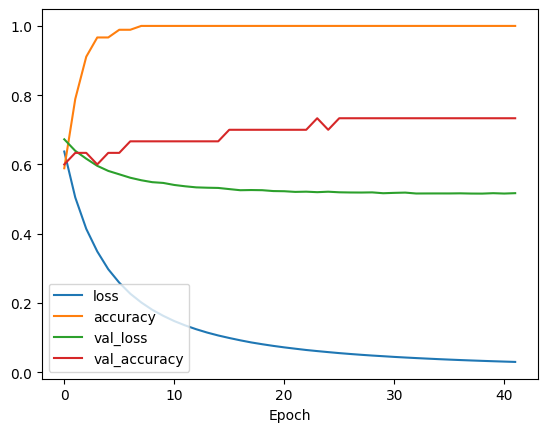

In [ ]:
history_plot = history_df.plot(xlabel='Epoch')

Save the figure in a file in your Drive folder.

In [ ]:
pic = history_plot.get_figure()
write_fig(pic, 'history')

## 6.2 Evaluating the model


Once we fit the model we can use the method ```model.evaluate()``` to obtain the accuracy on test set.

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
write_text(f'{score[1]:.2f}', 'accuracy')

1/1 [==============================] - 0s 129ms/step - loss: 0.3777 - accuracy: 0.8667


Get the predictions on the test set. Print a few of them.

In [ ]:
y_predict = (model.predict(x_test) > 0.5).astype("int32")
y_predict[:10]

1/1 [==============================] - 0s 112ms/step


array([[0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0]], dtype=int32)

Report metrics.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86        12
           1       1.00      0.78      0.88        18

    accuracy                           0.87        30
   macro avg       0.88      0.89      0.87        30
weighted avg       0.90      0.87      0.87        30



Produce the classification report as dict, convert to dataframe, drop accuracy and apply style.

In [ ]:
report_dict = classification_report(y_test, y_predict, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df.drop('accuracy', inplace=True)
#report_df.drop(columns='support', inplace=True)
report_styled = report_df.style.format(precision=2).highlight_max()
report_styled

,precision,recall,f1-score,support
0,0.75,1.00,0.86,12.00
1,1.00,0.78,0.88,18.00
macro avg,0.88,0.89,0.87,30.00
weighted avg,0.90,0.87,0.87,30.00


Now write the classification report to a latex table.

In [ ]:
write_table(report_styled, 'metrics',
  caption='Metrics for model '+workflow, label='tab:metrics', column_format='rrrrr')

Confusion matrix. Rows are actual classes, columns are classifications by the model.

In [ ]:
cm = math.confusion_matrix(labels=y_test, predictions=y_predict)
print(cm)

tf.Tensor(
[[12  0]
 [ 4 14]], shape=(2, 2), dtype=int32)


Display the confusion matrix as a heatmap.

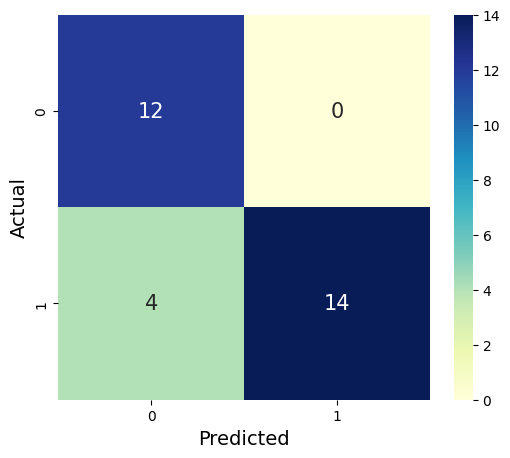

In [ ]:
plt.figure(figsize = (6,5))
heatmap = sns.heatmap(cm, annot=True, annot_kws={"size": 15},
                cmap = 'YlGnBu', vmin=0, fmt='d') # integers
heatmap.set_xlabel('Predicted', fontsize=14)
heatmap.set_ylabel('Actual', fontsize=14)
write_fig(plt, 'cm-heatmap')
plt.show()

## 6.3 Model Tuning

Add L2 regularizer. Regularization is an estimator that reduces variance signiﬁcantly while not overly increasing the bias. L1 regularization tends to make some weights zero, while L2 regularization makes all weights somewhat smaller.

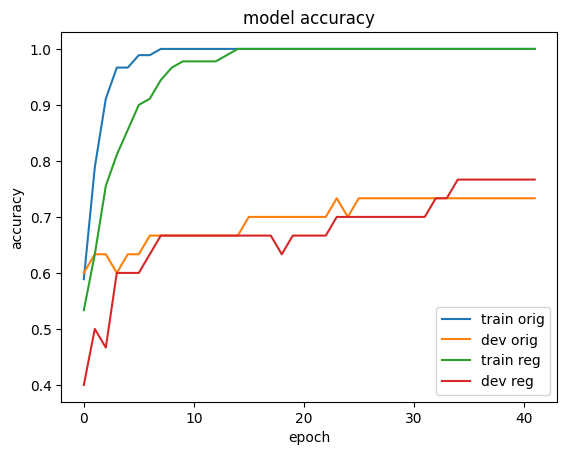

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers, regularizers

model2 = Sequential()

# add L2 weight regularization to logistic regression
regularizer = regularizers.l2(0.000002)
model2.add(Dense(units=1, activation='sigmoid', input_shape=(input_size,), kernel_regularizer=regularizer))

# Init optimizer
opt = optimizers.Adam()
model2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
history_reg = model2.fit(x_train, y_train, epochs=42, batch_size=32, validation_data=(x_dev, y_dev), verbose=0)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.plot(history_reg.history['accuracy'])
plt.plot(history_reg.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train orig', 'dev orig', 'train reg', 'dev reg'], loc='lower right')
write_fig(plt, 'history-reg')
plt.show()

## 6.4 Evaluating the tuned model


Once we fit the model we can use the method ```model.evaluate()``` to obtain the accuracy on test set.

In [ ]:
score = model2.evaluate(x_test, y_test, verbose=1)
write_text(f'{score[1]:.2f}', 'accuracy-reg')

1/1 [==============================] - 0s 27ms/step - loss: 0.4412 - accuracy: 0.9000


Get the predictions on the test set. Print a few of them.

In [ ]:
y_predict = (model2.predict(x_test) > 0.5).astype("int32")
y_predict[:10]

1/1 [==============================] - 0s 49ms/step


array([[0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0]], dtype=int32)

Report metrics.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89        12
           1       1.00      0.83      0.91        18

    accuracy                           0.90        30
   macro avg       0.90      0.92      0.90        30
weighted avg       0.92      0.90      0.90        30



Produce the classification report as dict, convert to dataframe, drop accuracy and apply style.

In [ ]:
report_dict = classification_report(y_test, y_predict, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df.drop('accuracy', inplace=True)
#report_df.drop(columns='support', inplace=True)
report_styled = report_df.style.format(precision=2).highlight_max(color='LimeGreen')
report_styled

,precision,recall,f1-score,support
0,0.80,1.00,0.89,12.00
1,1.00,0.83,0.91,18.00
macro avg,0.90,0.92,0.90,30.00
weighted avg,0.92,0.90,0.90,30.00


Now write the classification report to a latex table.

In [ ]:
write_table(report_styled, 'metrics-reg',
  caption='Metrics for model '+workflow+' with regularization',
  label='tab:metrics-reg', column_format='rrrrr')

Confusion matrix. Rows are actual classes, columns are classifications by the model.

In [ ]:
cm = math.confusion_matrix(labels=y_test, predictions=y_predict)
print(cm)

tf.Tensor(
[[12  0]
 [ 3 15]], shape=(2, 2), dtype=int32)


Display the confusion matrix as a heatmap.

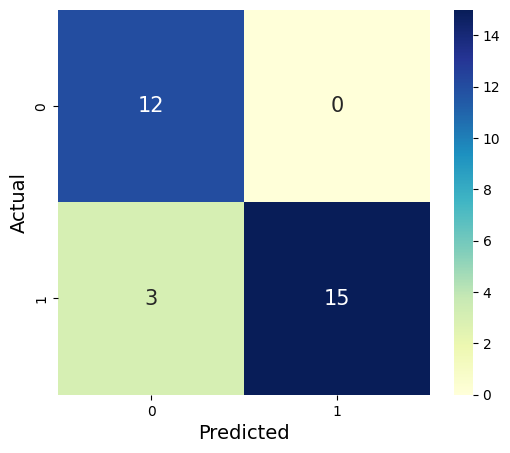

In [ ]:
plt.figure(figsize = (6,5))
heatmap = sns.heatmap(cm, annot=True, annot_kws={"size": 15},
                cmap = 'YlGnBu', vmin=0, fmt='d') # integers
heatmap.set_xlabel('Predicted', fontsize=14)
heatmap.set_ylabel('Actual', fontsize=14)
write_fig(plt, 'cm-heatmap-reg')
plt.show()